## LoyaltyOne 24-hour Hackathon

*Author*: Margarita Popova <br>
*Contact*: margeorita@gmail.com

 [Introduction](#Introduction)

1. [Data wrangling](#Data-wrangling)
2. [Exploratory analysis](#Exploratory-analysis)
3. [Data Wrangling](#Data-Wrangling)
4. [Split the Data into Train and Test Set](#Split-the-Data-into-Train-and-Test-Set)
5. [Vectorization of Text Data](#Vectorization-of-Text-Data)

#### Introduction

The following notebook was created during a 24-hour collaborative tech sprint for BrainStation students to create digital solutions for BrainStations' Industry Partner - LoyaltyOne.

Over an intensive period of brainstorming, discussion and iteration, with check-ins from the BrainStation team, our
multidisciplinary team has created a digital solution designed to increase program adoption with Millennials and
Gen Z.


Team consisted of:
 - 1 Data Scientist - Margarita Popova, author of the current analysis
 - 2 UX Designers - Malu Bongestab, Ines Aliu
 - 2 Web Developers - Ruoxin He, Kim Cang Ho
 - 1 Project Manager - Pranav

Our solution included an analysis of the current LoyaltyOne application to detect the existing issues. I decided to download some LoyaltyOne application users' reviews from App Store to highlight which what issues users faced. For that kind of analysis, Natural Language Processing (NLP) techniques were used.

#### Data wrangling

To perform NLP analysis from App Store  101 random LoyaltyOne app reviews were downloaded. These reviews were organized as a small csv-database with 4 fields:
 - `oid` - unique id, ordinal number
 - `positive` - positive reviews with a score higher than 3
 - `negative` - negative reviews with a score lower than 3
 - `score` - the number of stars which were left by a user

The csv-file is attached.

Let's import the necessary libraries for NLP analysis.

In [1]:
#import necessary Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import nltk

Now we can open the database and check some strings.

In [28]:
#open csv-file
lo_df = pd.read_csv("LoyaltyOne_review.csv", encoding= 'unicode_escape', index_col=0)
#look at 3 first rows
lo_df.head(3)

,positive,negative,score
oid,,,
1,It is good that there is AIR MILES REWARDS PRO...,no negative,5
2,2nd UPDATE: Uninstalled and reinstalled the ap...,no negative,4
3,no positive,There was absolutely nothing wrong with the pr...,1


Note the field `positive` contains the value `no positive` in some strings and the field `negative` contains the values `no negative`. These phrase-fillers were created to avoid missing values. We can not perform NLP using a database with missing values.

In [29]:
#sanity check of data format in the fields
lo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 1 to 100
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   positive  101 non-null    object
 1   negative  101 non-null    object
 2   score     101 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.2+ KB


In [32]:
#check the shape of the dataset
lo_df.shape
print(f'The datset contains {lo_df.shape[1]} columns and {lo_df.shape[0]} rows.')

The datset contains 3 columns and 101 rows.


In [23]:
#sanity check of missing values
lo_df.isna().sum()

positive    0
negative    0
score       0
dtype: int64

#### Exploratory analysis

Let's check the distribution of user scores in the dataset.

In [24]:
#group by scores
lo_df.groupby(by='score')['score'].count()

score
1    55
2    14
3    13
4    12
5     7
Name: score, dtype: int64

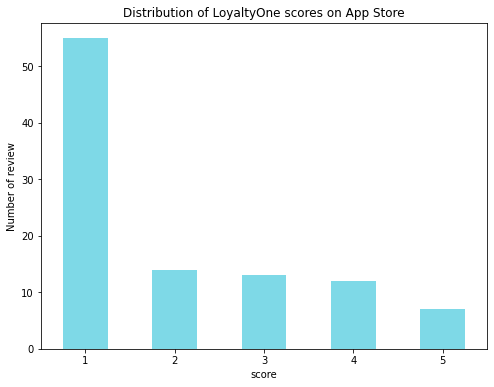

In [25]:
#plot the distribution of the scores
plt.figure(figsize=(8,6))

lo_df.groupby(by='score')['score'].count().plot(kind='bar', color = '#7ED9E7')
plt.xticks(rotation=0)
plt.ylabel('Number of review')
plt.title('Distribution of LoyaltyOne scores on App Store')

plt.show()

As we can see in the plot, the majority of the scores were negative:
 - 55 reviews with 1 star
 - 14 reviews with 2 stars
 - 13 reviews with 3 stars
 - 12 reviews with 4 stars
 - 7 reviews with 5 stars

To make the analysis easier we should binarize scores. Let's set the scores greater than 3 as 1 - `good` and scores less than 3 as 0 - `not good`. We count 3 as `good` to compensate for a little bit huge imbalance between positive and negative scores.

In [26]:
#turn the scores greater than 3 in 1, others in 0
lo_df['score'] = np.where(lo_df['score'] >= 3, 1, 0)

In [27]:
#count the distribution of the scores
lo_df.groupby(by='score')['score'].count()

score
0    69
1    32
Name: score, dtype: int64

Now we have 69 of negative scores and 32 of positive. Let's plot it.

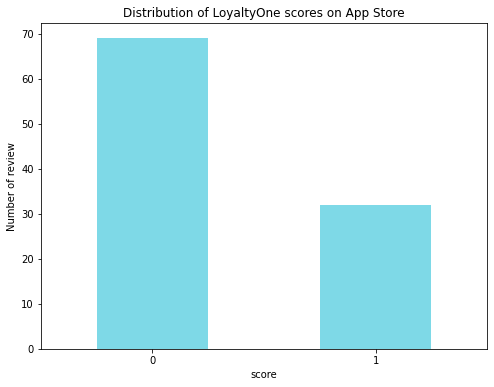

In [16]:
#plot the distribution of the binarized scores
plt.figure(figsize=(8,6))

lo_df.groupby(by='score')['score'].count().plot(kind='bar', color = '#7ED9E7')
plt.xticks(rotation=0)
plt.ylabel('Number of review')
plt.title('Distribution of LoyaltyOne scores on App Store')

plt.show()

#### Split the Data into Train and Test Set

Before we start to vectorize data in columns with users reviews we should split the dataset into train and test subsets.

Positive and Negative reviews become the X and the Users Score column becomes the y, because scores depend on the emotional tones of reviews.

In [33]:
# store data in X and y
X = lo_df[['negative', 'positive']]
y = lo_df['score']

Split dataset into train and test subset with ratio 0.7-train subset / 0.3-test subset.

In [34]:
# splitting our data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [35]:
#check shape of subsets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70, 2), (31, 2), (70,), (31,))

In [37]:
#look at some positive rewiews
X_train[['positive']].sample(7)

,positive
oid,
34,no positive
75,I have always liked the air miles program as i...
71,no positive
55,Love being an Airmiles collector been doing it...
80,no positive
58,no positive
92,no positive


In [38]:
#look at some negative rewiews
X_train[['negative']].sample(7)

,negative
oid,
72,"Not what it was, the amount of money to spend ..."
49,The phone lines to book a rental car are only ...
57,"After signing in, app only displays digital AM..."
92,"Tried to use it for the first time, and it say..."
42,t won't let me play carousel of dreams..keeps ...
86,no negative
37,"Not very user friendly, customer service is li..."


#### Vectorization of Text Data

In order to find issues that users are experiencing, we must create a sparse matrix of word tokens for negative reviews. 
To detect the issues we will estimate the words which occur frequently in the reviews with negative scores.

Obviously that the most frequent words will be prepositions, articles and pronouns, so we should exclude them from the analysis. We can set stop-words equal to 'English' to avoid articles, pronouns and prepositions.

Also, we will include in the stop-words fillers - `no negative` and `no positive` and meaningless words such as `app`, and the name of the app - `air miles`

First, let's create a list of meaningless words and numbers.

In [116]:
#create custom list of words
custom_list = ['no', 'negative', 'positive', 'app', 'miles', 'air', 'issue','airmiles','10', '1000', '120', '13', '130', '14', '150', '20', '247',
       '24hrs', '28th', '2nd', '30', '40w', '42', '4th', '700', '7nable',
       '90', '9000']

Now we should add that list to the existing corpus with prepositions, articles and pronouns.

In [117]:
#expand 'english' stop-words with custom_list
my_stopwords = nltk.corpus.stopwords.words('english')
my_stopwords.extend(custom_list)

Using the extended list of stop-words we can vectorize our reviews.

In [118]:
# Instantiate CountVectorizer with stop_words
bagofwords = CountVectorizer(stop_words=my_stopwords)

In [119]:
# Fit CountVectorizer
bagofwords.fit(X_train['negative'])
bagofwords.get_feature_names_out()

array(['abandoning', 'ability', 'able', 'absolutely', 'accept',
       'acceptable', 'access', 'account', 'acct', 'accumulate',
       'accumulation', 'act', 'actual', 'actually', 'added', 'addresses',
       'advertising', 'advising', 'aeroplan', 'afford', 'agents', 'ago',
       'ahould', 'airlines', 'allowed', 'almost', 'alot', 'also',
       'altenivtive', 'always', 'amd', 'amount', 'android', 'annoying',
       'another', 'answer', 'answers', 'anymore', 'ap', 'apple',
       'applied', 'area', 'around', 'ask', 'asked', 'asking', 'asks',
       'associated', 'attempts', 'autoload', 'available', 'away', 'back',
       'bad', 'bag', 'balance', 'banner', 'bar', 'barcode', 'beer',
       'behind', 'benefit', 'better', 'biggest', 'block', 'bmo', 'book',
       'brands', 'bright', 'brightness', 'broke', 'buck', 'bugs', 'bulb',
       'bulk', 'burnt', 'button', 'buy', 'buying', 'bypass', 'cache',
       'call', 'canada', 'canadian', 'cancels', 'cannot', 'cant', 'cap',
       'car', 'card'

In [120]:
#Transform train subset into matrix
X_train_transformed = bagofwords.transform(X_train['negative'])
#Transform test subset into matrix
X_test_transformed = bagofwords.transform(X_test['negative']) 

In [121]:
#check matrix metrics
X_train_transformed

<70x660 sparse matrix of type '<class 'numpy.int64'>'
	with 1085 stored elements in Compressed Sparse Row format>

Our sparse matrix contains 70 rows and 662 columns with word tokens.

We may look at the top 30 words and visualize the distribution of counts with bar plot

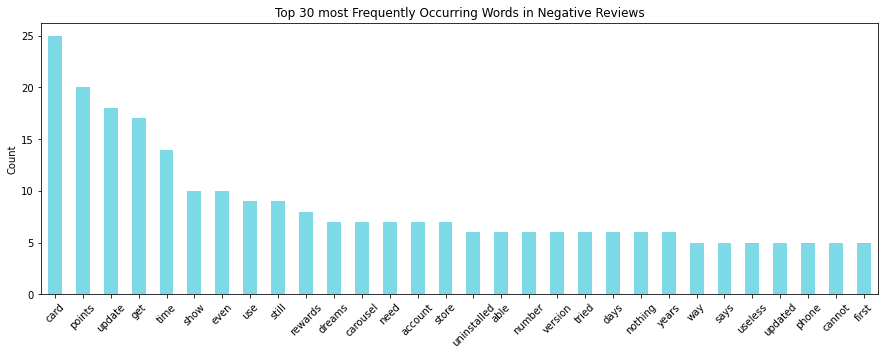

In [122]:
#create data frame out of sparse matrix
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names_out()
).sort_values("counts", ascending=False)

#perform bar plot
word_counts.head(30).plot(kind="bar", figsize=(15, 5), legend=False, color='#7ED9E7')
plt.title("Top 30 most Frequently Occurring Words in Negative Reviews")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

According the plot the most friquen words in reviews are:
 - card
 - points
 - update
 - get
 - time

We can conclude that the most important issues for users were related to the system of points, with application updates and with timing.

Users did not like to spend a lot of time for registration in the app and familiarisation with the app. The second important issue is that the users did not like or did not understand the system of points and rewards, moreover, they had problems with scoring their points. Also, there were issues with updates to the application. 

All these conclusions we received with NLP of 101 reviews. Bigger datasets which are including thousands and millions of reviews allow us to get more precise data, but for the 24-hour hackathon use of such a big dataset is unsensible.